# Text EDA

In [1]:
import pandas as pd
import numpy as np
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk import ne_chunk, pos_tag
from nltk.tree import Tree
import spacy
from wordcloud import WordCloud, STOPWORDS
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from matplotlib import pyplot as plt
%matplotlib inline
from textblob import Word
from textblob import TextBlob
import gensim
from gensim.models.phrases import Phrases, Phraser
from gensim.models import KeyedVectors

C:\ProgramData\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


# Load data in dataframe

In [2]:
df = pd.read_csv("nlp_data.txt", header=None, sep="\n", names=["text"])

In [3]:
df.head()

,text
0,Natural language processing -LRB- NLP -RRB- is...
1,"Specifically , it is the process of a computer..."
2,"In theory , natural language processing is a v..."
3,Natural language understanding is sometimes re...
4,"Whether NLP is distinct from , or identical to..."


# Text pre-processing and visualizations

Converting all statements to lower case. This reduces redundancy and normalize words with upper case letters in between. I'm storing the formatted text in another column because I'll need the original text to identify entities, which will be lost if converted to lower case.

In [4]:
df['text_lower'] = df['text'].apply(lambda x: " ".join(x.lower() for x in x.split()))
df.head()

,text,text_lower
0,Natural language processing -LRB- NLP -RRB- is...,natural language processing -lrb- nlp -rrb- is...
1,"Specifically , it is the process of a computer...","specifically , it is the process of a computer..."
2,"In theory , natural language processing is a v...","in theory , natural language processing is a v..."
3,Natural language understanding is sometimes re...,natural language understanding is sometimes re...
4,"Whether NLP is distinct from , or identical to...","whether nlp is distinct from , or identical to..."


## Wordcloud with Unigrams

Generating unigram wordcloud to see important words in the text.

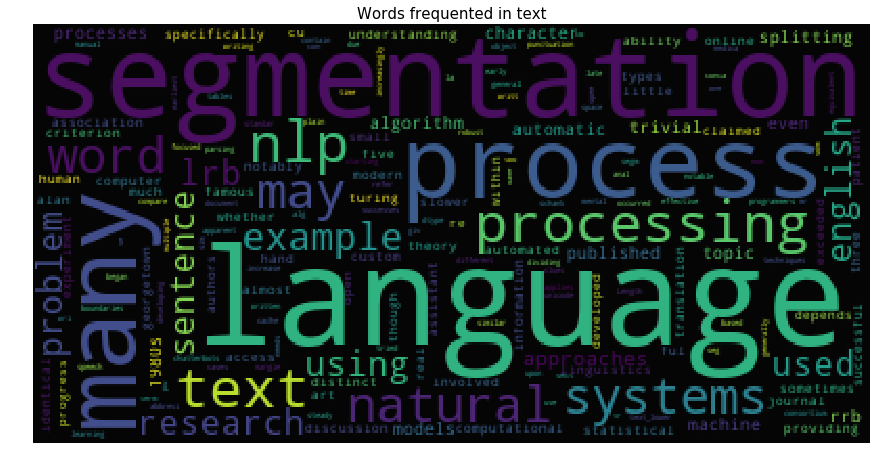

In [5]:
stopwords = set(STOPWORDS)
wordcloud = WordCloud(
                        background_color='black',
                        stopwords=stopwords,
                        max_words=200, 
                        random_state=42).generate(str(df['text_lower']))

plt.figure(figsize=(15,10))
plt.axis("off")
plt.title("Words frequented in text", fontsize=15)
plt.imshow(wordcloud.recolor(colormap= 'viridis' , random_state=42), alpha=0.98)
plt.show()

Stopwords like "a", "the" etc are not useful while working with text, in general. The better way is to have a custom stopwords list relevant to the use case because words like "of" can be present in company name and we don't want that to be removed. For the purpose of this problem and time constraint I'm going with the general list.

In [6]:
df['text'] = df['text'].apply(lambda x: " ".join(x for x in x.split() if x not in stopwords))
df['text_lower'] = df['text_lower'].apply(lambda x: " ".join(x for x in x.split() if x not in stopwords))
df.head()

,text,text_lower
0,Natural language processing -LRB- NLP -RRB- fi...,natural language processing -lrb- nlp -rrb- fi...
1,"Specifically , process computer extracting mea...","specifically , process computer extracting mea..."
2,"In theory , natural language processing attrac...","theory , natural language processing attractiv..."
3,Natural language understanding sometimes refer...,natural language understanding sometimes refer...
4,"Whether NLP distinct , identical , field compu...","whether nlp distinct , identical , field compu..."


Putting "(" and ")" in place of its POS tag. This step is not necessary but as I have to work with words in general for finding similarities and closest matches, I need these as punctuations. 

In [7]:
df['text_lower'] = df['text_lower'].apply(lambda x: x.replace("-lrb-", "("))
df['text_lower'] = df['text_lower'].apply(lambda x: x.replace("-rrb-", ")"))
df['text'] = df['text'].apply(lambda x: x.replace("-LRB-", "("))
df['text'] = df['text'].apply(lambda x: x.replace("-RRB-", ")"))
df.head()

,text,text_lower
0,Natural language processing ( NLP ) field comp...,natural language processing ( nlp ) field comp...
1,"Specifically , process computer extracting mea...","specifically , process computer extracting mea..."
2,"In theory , natural language processing attrac...","theory , natural language processing attractiv..."
3,Natural language understanding sometimes refer...,natural language understanding sometimes refer...
4,"Whether NLP distinct , identical , field compu...","whether nlp distinct , identical , field compu..."


I tried using Lemmatization but it was reducing some words to incorrect base form beacuse the lemmatizer has no knowledge of the dataset, so I'm skipping it. Lemmatization and Stemming should be used carefully as they can destroy important words.

In [8]:
# df['text'] = df['text'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
# df['text'].head()

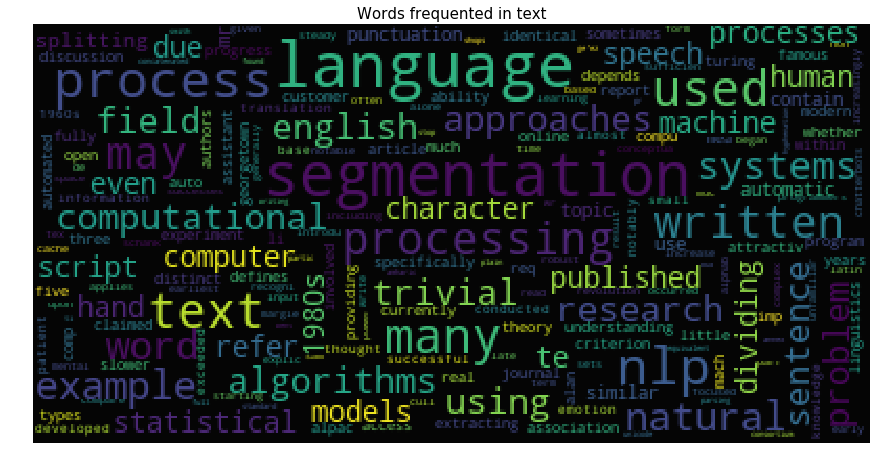

In [9]:
wordcloud = WordCloud(
                        background_color='black',
                        stopwords=stopwords,
                        max_words=200,
                        max_font_size=30,
                        random_state=42).generate(str(df['text_lower']))

plt.figure(figsize=(15,10))
plt.axis("off")
plt.title("Words frequented in text", fontsize=15)
plt.imshow(wordcloud.recolor(colormap= 'viridis' , random_state=42), alpha=0.98)
plt.show()

Wordcloud with some cleaned text. We can see that it is somewhat better than the previous one as it brings down the importance of some words like **segmentation**, **many** etc., which are not important to this text.

## Wordcloud with Trigrams and Bigrams

Looking at the text, its relevance is to **Natural Language Processing**. This word is not covered in unigrams so we to have trigrams and bigrams which will give much more information about the corpus.

Using **Gensim's Phrases** we can generate bigrams and trigrams.

In [10]:
sentences=[text.split() for text in df.text_lower.values]
phrases = Phrases(sentences)
bigram = Phraser(phrases)
trigram = Phrases(bigram[sentences])

In [11]:
df['trigrams'] = df['text_lower'].apply(lambda x: " ".join(trigram[bigram[x.split()]]))
df.head()

C:\ProgramData\Anaconda3\lib\site-packages\gensim\models\phrases.py:494: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


,text,text_lower,trigrams
0,Natural language processing ( NLP ) field comp...,natural language processing ( nlp ) field comp...,natural_language_processing ( nlp ) field comp...
1,"Specifically , process computer extracting mea...","specifically , process computer extracting mea...","specifically , process computer extracting mea..."
2,"In theory , natural language processing attrac...","theory , natural language processing attractiv...","theory , natural_language_processing attractiv..."
3,Natural language understanding sometimes refer...,natural language understanding sometimes refer...,natural_language_understanding sometimes refer...
4,"Whether NLP distinct , identical , field compu...","whether nlp distinct , identical , field compu...","whether nlp distinct , identical , field compu..."


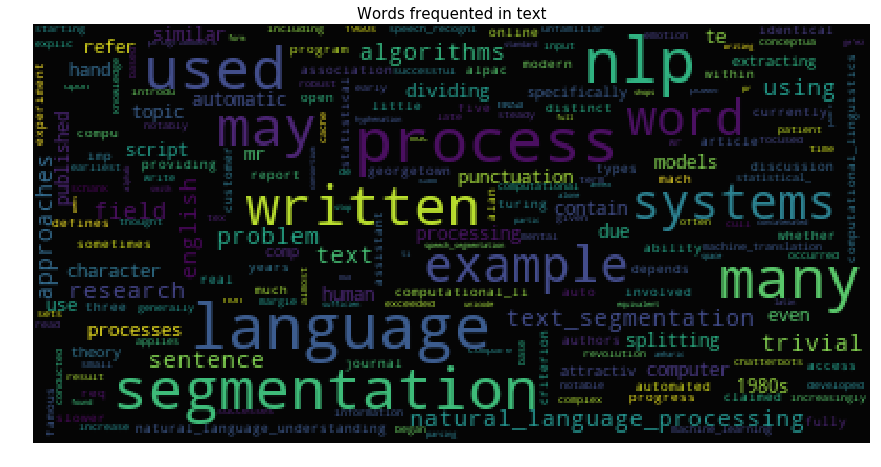

In [12]:
stopwords = set(STOPWORDS)
wordcloud = WordCloud(
                        background_color='black',
                        stopwords=stopwords,
                        max_words=200,
                        max_font_size=30,
                        random_state=42).generate(str(df['trigrams']))

plt.figure(figsize=(15,10))
plt.axis("off")
plt.title("Words frequented in text", fontsize=15)
plt.imshow(wordcloud.recolor(colormap= 'viridis' , random_state=42), alpha=0.98)
plt.show()

This is a much better wordcloud which clearly shows what this corpus is talking about. **nlp** is more highlighted now. Words like **natural_language_processing** and **text_segmentation** are visible now which were not there in previuos cases.

# Finding entities in text

I'm using **spacy** to get the enitities present in the text. I'm using **en_core_web_sm** model of spacy which is pre-trained in general english dictionary. As this is a demo work, this step should work but in real product development cases this step should not be done. The model should be trained according to the business need so that it can map the correct entities. Like in this case, the model is mappling **NLP** to **ORG** label because that's what it is trained like, all caps words should be organization names.

It also fails to recognize **Natural language processing** as an entity because it has not be trained to do so.

In [13]:
def get_entities(text):
    parsed_text = nlp(text)
    entities = list(parsed_text.ents)
    named_entities = []
    for entity in entities:
        if entity.label_ in ["ORG", "PERSON"]:
            named_entities.append(entity)
    return named_entities

In [14]:
nlp=spacy.load('en_core_web_sm')

In [15]:
df['entities'] = df['text'].apply(get_entities)

In [16]:
df.head()

,text,text_lower,trigrams,entities
0,Natural language processing ( NLP ) field comp...,natural language processing ( nlp ) field comp...,natural_language_processing ( nlp ) field comp...,[(NLP)]
1,"Specifically , process computer extracting mea...","specifically , process computer extracting mea...","specifically , process computer extracting mea...",[]
2,"In theory , natural language processing attrac...","theory , natural language processing attractiv...","theory , natural_language_processing attractiv...",[]
3,Natural language understanding sometimes refer...,natural language understanding sometimes refer...,natural_language_understanding sometimes refer...,[]
4,"Whether NLP distinct , identical , field compu...","whether nlp distinct , identical , field compu...","whether nlp distinct , identical , field compu...",[(NLP)]


In [17]:
unique_entities = set()
for entry in df.entities.values:
    for entity in entry:
        if entity:
            if (len(entity.orth_.strip()) == 3 and entity.orth_.strip().isupper()) or len(entity.orth_.strip()) > 3:
                unique_entities.add(entity.orth_.strip())

unique_entities

{'A.C. Nielsen',
 'ACL',
 'ACL Anthology',
 'ALPAC',
 'ANR',
 'APEXC',
 'ARCHILES',
 'ASR',
 'AT&T',
 'ATC',
 'AVRADA',
 'Abney S.',
 'Adam Jaworski',
 'Adda G.',
 'Adriana Bolivar',
 'Advanced Fighter Technology Integration',
 'Aerospace',
 'Airline Ticket',
 'Alan Turing',
 'Alenia Aermacchi M-346 Master',
 'Alessandro Duranti',
 'Aletta Norval',
 'American Bible Society',
 'American Recovery Reinvestment Act',
 'Amharic Tigrinya',
 'Analysis',
 'Annotate',
 'Apollo',
 'Apple',
 'Application-Oriented OCR',
 'Applied linguistics Cognitive',
 'Armed Forces Security Agency',
 'Art Graesser',
 'Ask.com',
 'BLEU',
 'BORIS',
 'Barbara Johnstone',
 'Battle',
 'Battle Management',
 'Baum-Welch',
 'Bayes',
 'Beatrice Santorini',
 'Bernard Vauquois',
 'Bhatia',
 'Biden',
 'Birkbeck College',
 'Birkbeck College ( University London',
 'Black E.',
 'Braille',
 'Brenton D. Faber',
 'Brill',
 'Brill Tagger',
 'British National Corpus',
 'Brown Corpus',
 'Brown University',
 'Brown University Henry 

# Dependency Graph Example

Here I'm showing how **spacy** can be used to find the dependecy graph of a text. It is used to find triples (subject, relation, object). This piece also suffers from the same problem as stated above. Because of time constraint I'm not training the model with input data beacuse that would mean tagging entities with label so that they are combined wherever necessary like in the case of **Natural language processing**.

In [18]:
parsed_text=nlp(df.text.values[0])
for token in parsed_text:
    print(token.text, token.dep_, token.head.text, token.head.pos_,
          [child for child in token.children])

Natural amod language NOUN []
language compound processing NOUN [Natural]
processing nmod languages NOUN [language, science]
( punct science NOUN []
NLP nmod science NOUN []
) punct science NOUN []
field compound computer NOUN []
computer compound science NOUN [field]
science parataxis processing NOUN [(, NLP, ), computer, ,, intelligence, ,]
, punct science NOUN []
artificial amod intelligence NOUN []
intelligence conj science NOUN [artificial, (, learning, )]
( punct intelligence NOUN []
called amod learning NOUN []
machine compound learning NOUN []
learning appos intelligence NOUN [called, machine]
) punct intelligence NOUN []
, punct science NOUN []
linguistics npadvmod concerned ADJ []
concerned amod languages NOUN [linguistics]
interactions compound computers NOUN []
computers nmod languages NOUN [interactions]
human nmod languages NOUN []
( punct languages NOUN []
natural amod languages NOUN []
) punct languages NOUN []
languages ROOT languages NOUN [processing, concerned, compu

In [19]:
from spacy import displacy

displacy.render(parsed_text, style='dep', jupyter=True, options={'compact': True, 'offset_x': 30, 'word_spacing': 20})

# Word2Vec to analyze given text

Here I'm going with 2 approaches:
 - Use GloVe pretrained model to find word vectors
 - Train word2vec model with given data and check for improvements

## Using GloVe

GloVe is an unsupervised learning algorithm for obtaining vector representations for words. Training is performed on aggregated global word-word co-occurrence statistics from a corpus, and the resulting representations showcase interesting linear substructures of the word vector space.

Gensim can be used to load this model and find similarity between 2 words, using cosine similarity. Which can tell us what the text is talking about.

Let's see if GloVe is useful to this case.

In [20]:
word_vector = gensim.models.KeyedVectors.load_word2vec_format("glove.txt", binary=False)

In [21]:
word_vector.wv.similarity('language', 'nlp')

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """Entry point for launching an IPython kernel.


0.035043008662177841

The similarity between these 2 words is very low, but we know that they are connected.

In [22]:
word_vector.wv.similarity('machine learning', 'nlp')

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """Entry point for launching an IPython kernel.


KeyError: "word 'machine learning' not in vocabulary"

The word **machine learning** is not even in GloVe's vocabulary.

**This shows us that no matter what model we use, it requires some sense of the text it is encountering. This can only be done with self-training the model.**

## Self-trained word2vec model

I'm now going to train word2vec using the corpus. I'm going to cover 3 cases:
 - Unigrams
 - Bigrams
 - Trigrams

In [23]:
sentences=[text.split() for text in df.text_lower.values]

### Unigrams

In [24]:
model = gensim.models.Word2Vec(sentences, min_count=1,size=300,workers=4,window=5)

In [25]:
model.wv.similarity('language', 'nlp')

0.99981449131993327

This similarity tells us that these 2 words are clearly related as we know.

In [26]:
model.wv.similarity('hmm', 'nlp')

0.87416138836466817

This also shows us that HMM (Hidden Markov Model) is very much related to NLP.

### Bigrams

In [27]:
phrases = Phrases(sentences)
bigram = Phraser(phrases)
sent = df.text_lower.values[0].split()
print(bigram[sent])

['natural_language', 'processing', '(', 'nlp', ')', 'field', 'computer', 'science', ',', 'artificial_intelligence', '(', 'called', 'machine_learning', ')', ',', 'linguistics', 'concerned', 'interactions', 'computers', 'human', '(', 'natural', ')', 'languages', '.']


In [28]:
bigram_transformer = gensim.models.Phrases(sentences)
model = gensim.models.Word2Vec(bigram_transformer[sentences], min_count=1,size=300,workers=4,window=5)

C:\ProgramData\Anaconda3\lib\site-packages\gensim\models\phrases.py:494: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [29]:
model.wv.similarity('machine_learning', 'nlp')

0.99862521340483568

This shows us that not only do we have machine learning in our vocabulary now, but also that it has a strong similarity with nlp.

In [30]:
model.wv.similarity('computational_linguistics', 'nlp')

0.995820146790376

Similarly in this case.

### Trigrams

In [31]:
trigram = Phrases(bigram[sentences])
sent = df.text_lower.values[2].split()
print(trigram[bigram[sent]])

C:\ProgramData\Anaconda3\lib\site-packages\gensim\models\phrases.py:494: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


['theory', ',', 'natural_language_processing', 'attractive', 'method', 'human', '--', 'computer', 'interaction', '.']


In [32]:
trigram_transformer = Phrases(bigram[sentences])
model = gensim.models.Word2Vec(trigram_transformer[bigram[sentences]], min_count=1,size=300,workers=4,window=5)

C:\ProgramData\Anaconda3\lib\site-packages\gensim\models\phrases.py:494: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [33]:
model.wv.similarity('natural_language_processing', 'nlp')

0.99907048977268997

Finally we can see that our trained model is able to tell us that natural_language_processing and nlp are almost the same things.